Microsoft Differential Privacy Whitepaper Collateral Notebooks Part 4
# Privacy Preserving Machine Learning with Differential Privacy 

<img src="images/ml.jpg" width=800 />

The goal of this notebook is to demonstrate how to perform supervised machine learning on a tabular data with differential privacy. This ensures that the contribution of the individuals' data to the resulting machine learning model is masked out. Consequently it is not possible that information of individuals  may be leaked from the trained machine learning model.
Furthermore, our objective is to assess the impact of tha data set size and its complexity on resulting privacy levels and accuracy of the machine learning model. 



We are generating a synthetic dataset to control dataset size and difficulty of the classification problem. The flow of the demonstration is as follows:
1. Generate dataset for the supervised classification problem
2. Train a Random Forest classifier in a standard (non-private) fashion as benchmark for maximum achievable classification performance
3. Compare non-private and differentially private versions of Naive Bayes and Logistic Regression classifiers
4. Assess the impact of dataset size on privacy and performance

## Installs and imports

In [1]:
# %pip install diffprivlib seaborn

In [2]:
import warnings
# warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import seaborn as sns

## Generate dataset for supervised classification problem
We are using the `make_classification` function from Scikit Learn to generate a synthetic dataset as starting point. While it is not a real world dataset, the approach has the advantage that the characteristics of the data (e.g. number of features, classes, noise, amount of mislabeled instances and classification dificulty) can be controlled.

Our dataset has the following characteristics:

- 100,000 instances, 10 classes
- 20 ordinal features: mixture of relevant ('informative'), redundant, repeated and pure noise
- 3% of instances are mislabeled

In [3]:
n_samples = 100000
n_features = 20
n_informative = 7 # relevant features to explain target
n_redundant = 5 # linear combinations of informative
n_repeated = 5 # random copies of informative and redundant
n_useless = n_features - n_informative - n_redundant - n_repeated # noise

n_classes = 10
seed = 1

In [4]:
# define feature names
def feature_names (n_items, prefix = 'feature'):
    names = []
    for i in range(n_items):
        names.append(prefix + '_' + str(i))
    return names

inf_features = feature_names(n_informative, 'inf')
red_features = feature_names(n_redundant, 'red')
rep_features = feature_names(n_repeated, 'rep')
useless_features = feature_names(n_useless, 'noise')

feature_names = inf_features + red_features + rep_features + useless_features

X, y = make_classification(n_samples=n_samples, 
                    n_features=n_features, 
                    n_informative=n_informative, 
                    n_redundant=n_redundant, 
                    n_repeated=n_repeated, 
                    n_classes=n_classes, 
                    n_clusters_per_class=2, 
                    weights=None, 
                    flip_y=0.03, 
                    class_sep=5.0, 
                    hypercube=True, 
                    shift=15.0,
                    scale=0.5,
                    shuffle=False, 
                    random_state=seed)

### Convert classes to integer values

In [5]:
# Convert to Dataframe
Z=np.zeros((X.shape[0], X.shape[1]+1))
Z[:,:-1]=X
Z[:,-1]=y

columns = feature_names + ['class']

df = pd.DataFrame(Z, columns=columns)
df['class'] = df['class'].astype('int32')

In [6]:
df.head(8)

inf_0      inf_1      inf_2      inf_3     inf_4     inf_5      inf_6  \
0   9.622483  10.776050   9.671523   9.976871  4.844616  4.195274   9.181214   
1   8.758071  12.884599  10.786024  10.314471  5.946004  5.579375   9.461131   
2  10.950740   9.837627  10.308713   9.139833  5.224695  5.835789  10.724998   
3  10.208986   9.960696   9.952239  10.574564  5.025228  4.649186  10.239452   
4   8.706916   9.653345   9.507716  10.181471  4.246708  4.525342   8.781617   
5   9.991609  10.355507   9.751412   9.158743  5.020356  4.735739   9.818326   
6   9.941282  11.699600   9.892127   9.660871  5.674021  5.321591   9.691404   
7   9.913791   8.192438  10.011287   9.368032  4.281924  5.725948   9.876652   

      red_0      red_1      red_2  ...     red_4      rep_0     rep_1  \
0  4.206254  11.364924  11.943380  ... -1.245756   9.976871  4.195274   
1  2.172168  12.190966  12.695319  ... -2.836881  10.314471  5.579375   
2  3.084610  10.903938  11.752966  ...  1.012283   9.139833  5.835789   
3  3.667078  11.617880  11.409677  ... -0.996092  10.574564  4.649186   
4  4.947578  10.755563  10.173824  ... -1.476174  10.181471  4.525342   
5  3.850189  10.612499  11.804652  ...  0.021108   9.158743  4.735739   
6  3.301691  11.376314  12.592598  ... -0.360953   9.660871  5.321591   
7  4.433393  10.303285   9.674592  ...  0.719095   9.368032  5.725948   

      rep_2      rep_3      rep_4   noise_0   noise_1   noise_2  class  
0  4.844616   9.622483  10.776050  7.854951  7.272374  8.070449      0  
1  5.946004   8.758071  12.884599  6.740964  7.100400  8.059407      0  
2  5.224695  10.950740   9.837627  7.879185  7.651928  7.265565      0  
3  5.025228  10.208986   9.960696  7.966864  7.519276  7.818932      0  
4  4.246708   8.706916   9.653345  6.760420  6.687636  7.211290      0  
5  5.020356   9.991609  10.355507  7.994524  7.525371  7.724381      0  
6  5.674021   9.941282  11.699600  6.835219  7.720820  7.397612      0  
7  4.281924   9.913791   8.192438  7.041421  7.526699  7.312443      0  

[8 rows x 21 columns]

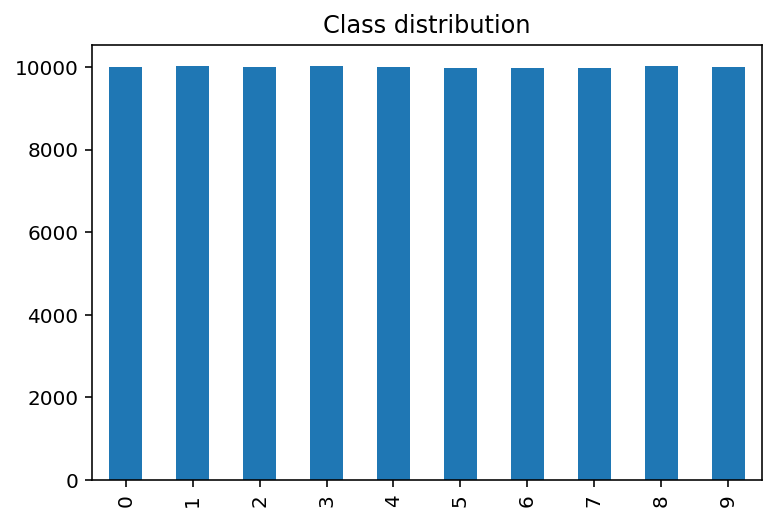

In [7]:
_ = df['class'].value_counts().sort_index().plot(kind='bar', title = 'Class distribution')

### Review pairs of selected features for an intuition of the classification difficulty

<Figure size 640x480 with 0 Axes>

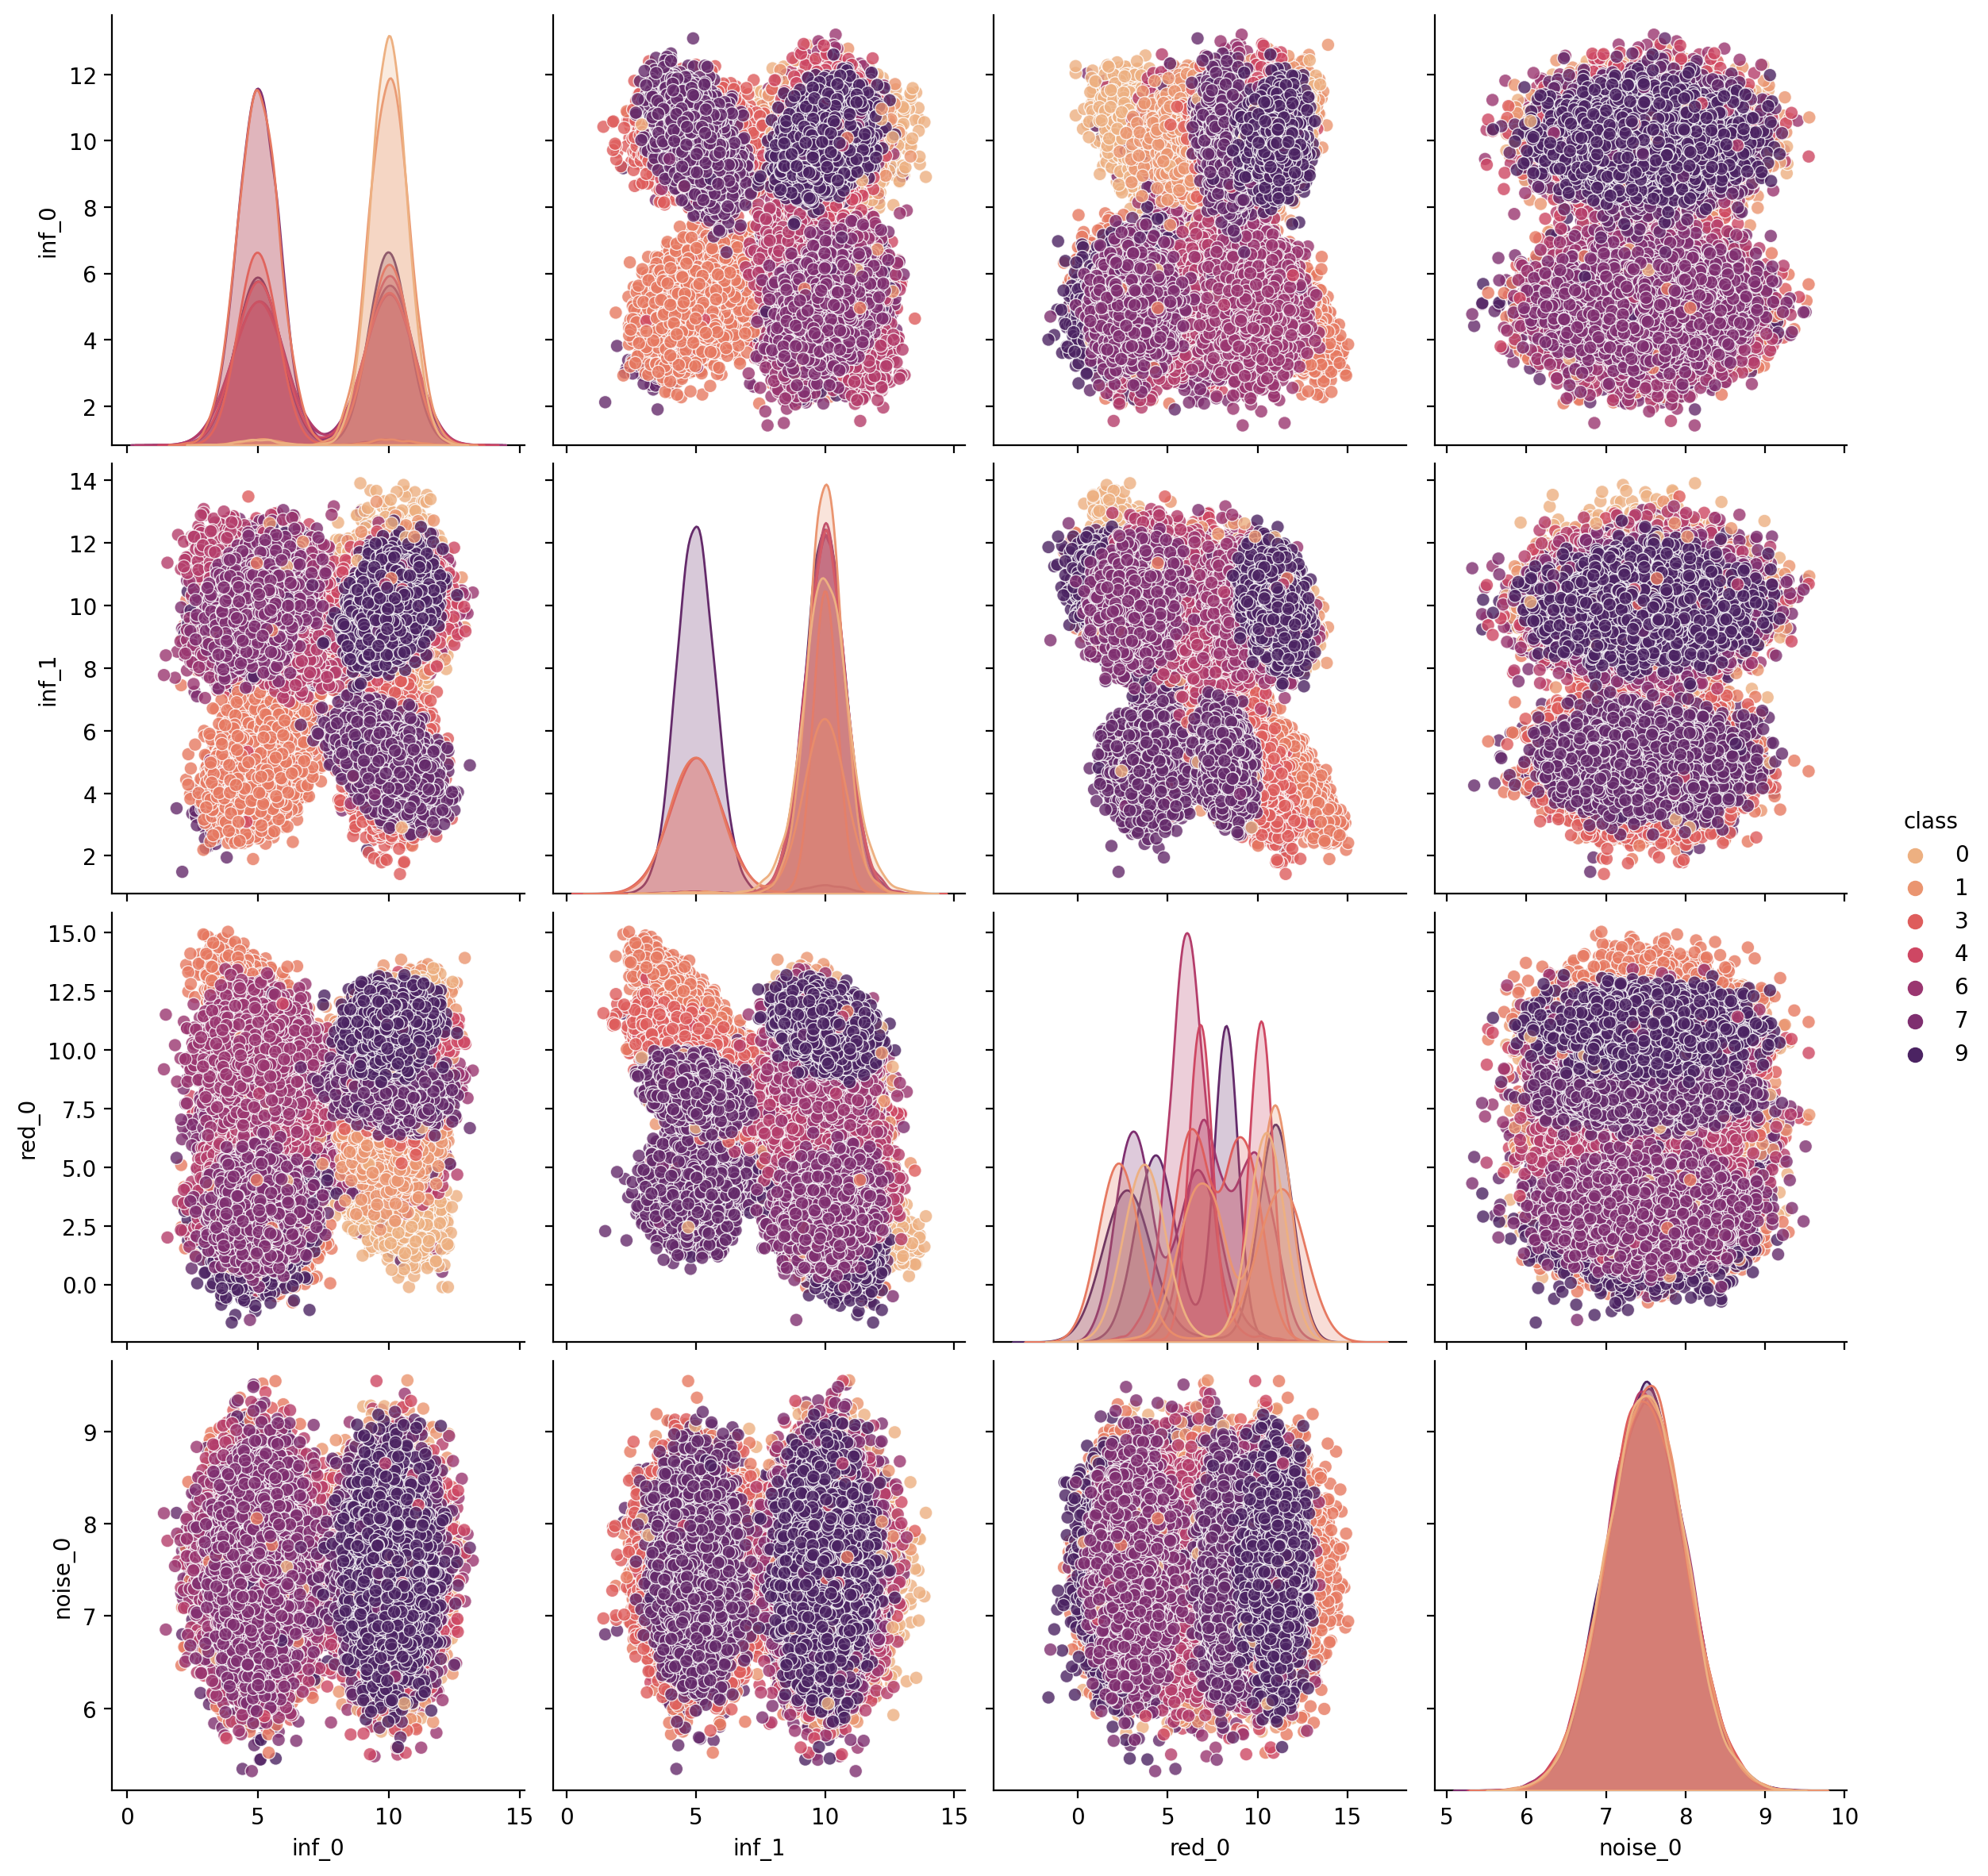

In [8]:
plot_features = inf_features[:2] + [red_features[0]] + [useless_features[0]]

plt.rcParams.update(plt.rcParamsDefault)
plt.clf()
g = sns.pairplot(df, vars=plot_features, height=3.0, hue='class', plot_kws=dict(alpha=0.8), palette='flare')
plt.show()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['class'],axis=1), df['class'], test_size=0.2, stratify = df['class'], random_state = seed)

scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

X_train_std = pd.DataFrame(X_train_std, columns=X_train.columns)
X_test_std = pd.DataFrame(X_test_std, columns=X_test.columns)

## Train a Random Forest classifier in a standard (non-private) fashion as benchmark
We are choosing a Random Forest for our baseline since this classifier typically have a strong performance and therefore should indicate the upper bound of achievable classification metrics for the given dataset. Since 3% of the instances are mislabeled, the maximum achievable accuracy level should be around 97%.

In [10]:
np.random.seed(seed)

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=seed)
clf.fit(X_train_std, y_train)
y_pred = clf.predict(X_test_std)
print(classification_report(y_test, y_pred))

y_probs = clf.predict_proba(X_test_std)
roc_score = roc_auc_score(y_test, y_probs, multi_class='ovo')
print('ROC AUC Score: %f' %roc_score)

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1999
           1       0.97      0.97      0.97      2006
           2       0.98      0.97      0.97      2000
           3       0.97      0.97      0.97      2006
           4       0.97      0.97      0.97      1999
           5       0.98      0.98      0.98      1996
           6       0.97      0.97      0.97      1993
           7       0.97      0.96      0.97      1996
           8       0.97      0.97      0.97      2005
           9       0.97      0.97      0.97      2000

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000

ROC AUC Score: 0.984806


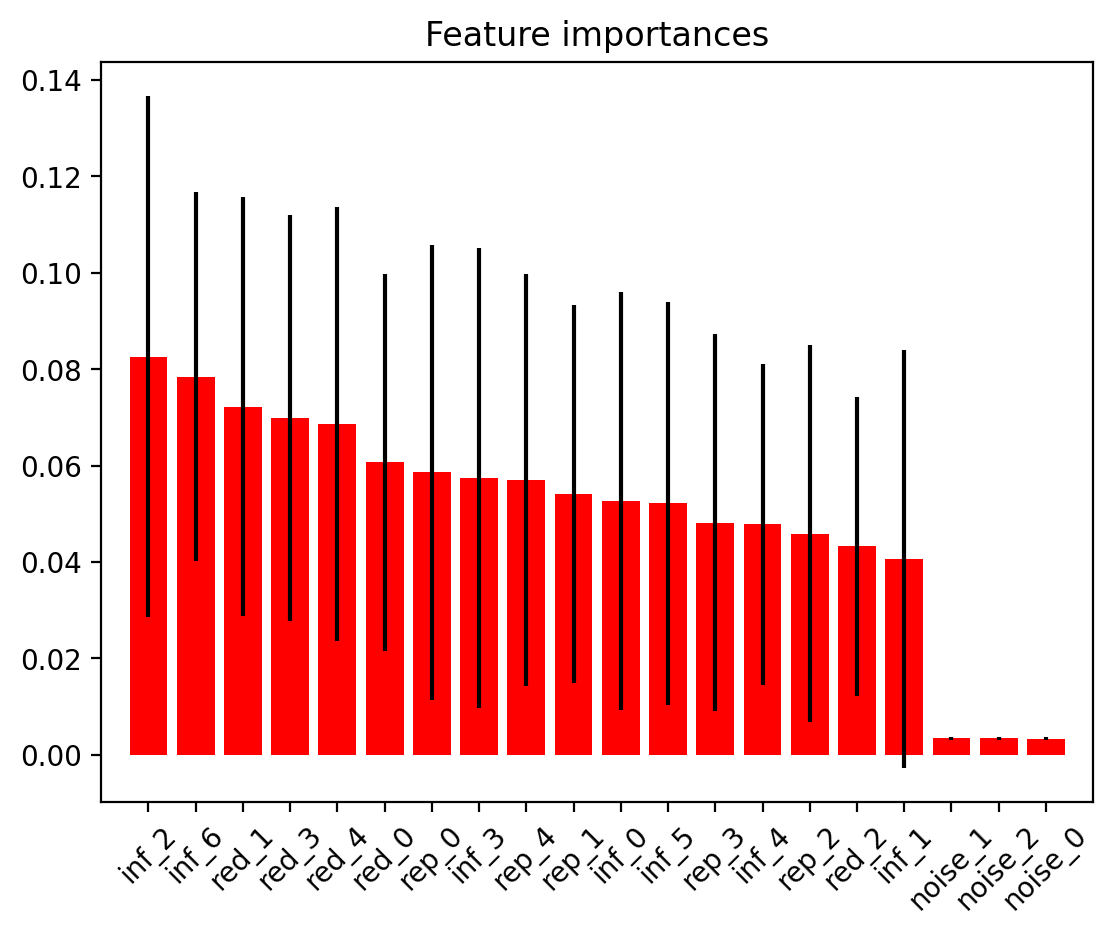

In [11]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Plot the impurity-based feature importances of the forest
x_labels = [feature_names[x] for x in indices]    
plt.figure()
plt.title("Feature importances")
plt.bar(x=x_labels, height=importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(rotation=45)
plt.xlim([-1, X.shape[1]])
plt.show()

## Compare non-private and differentially private versions of Naive Bayes and Logistic Regression classifiers

### Non-private version of Naive Bayes
Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable.

In [12]:
np.random.seed(seed)

from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train_std, y_train)
y_pred = clf.predict(X_test_std)
print(classification_report(y_test, y_pred))

y_probs = clf.predict_proba(X_test_std)
roc_score = roc_auc_score(y_test, y_probs, multi_class='ovo')
print('ROC AUC Score: %f' %roc_score)

              precision    recall  f1-score   support

           0       0.70      0.97      0.81      1999
           1       0.44      0.20      0.28      2006
           2       0.97      0.97      0.97      2000
           3       0.91      0.97      0.94      2006
           4       0.64      0.76      0.70      1999
           5       0.97      0.96      0.96      1996
           6       0.70      0.96      0.81      1993
           7       0.65      0.95      0.77      1996
           8       0.97      0.97      0.97      2005
           9       0.72      0.07      0.12      2000

    accuracy                           0.78     20000
   macro avg       0.77      0.78      0.73     20000
weighted avg       0.77      0.78      0.73     20000

ROC AUC Score: 0.969456


### Non-private version of Logistic Regression

In [13]:
np.random.seed(seed)

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter = 500)
clf.fit(X_train_std, y_train)
y_pred = clf.predict(X_test_std)
print(classification_report(y_test, y_pred))

y_probs = clf.predict_proba(X_test_std)
roc_score = roc_auc_score(y_test, y_probs, multi_class='ovo')
print('ROC AUC Score: %f' %roc_score)

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1999
           1       0.93      0.95      0.94      2006
           2       0.97      0.96      0.96      2000
           3       0.90      0.91      0.91      2006
           4       0.94      0.91      0.92      1999
           5       0.94      0.96      0.95      1996
           6       0.88      0.89      0.88      1993
           7       0.93      0.93      0.93      1996
           8       0.97      0.97      0.97      2005
           9       0.87      0.88      0.87      2000

    accuracy                           0.93     20000
   macro avg       0.93      0.93      0.93     20000
weighted avg       0.93      0.93      0.93     20000

ROC AUC Score: 0.982501


### Differentially private version of Naive Bayes

In [14]:
# Required parameters for DP version of Gaussian Naive Bayes
lower = list(X_train_std.min())
upper = list(X_train_std.max())
bounds = (lower, upper)

np.random.seed(seed)

from diffprivlib.models import GaussianNB, LogisticRegression # DP version of classifier

clf = GaussianNB(epsilon=1.0, bounds=bounds)

clf.fit(X_train_std, y_train)

y_pred = clf.predict(X_test_std)
print(classification_report(y_test, y_pred))

y_probs = clf.predict_proba(X_test_std)
roc_score = roc_auc_score(y_test, y_probs, multi_class='ovo')
print('ROC AUC Score: %f' %roc_score)

              precision    recall  f1-score   support

           0       0.66      0.96      0.78      1999
           1       0.40      0.08      0.14      2006
           2       0.97      0.96      0.97      2000
           3       0.84      0.96      0.90      2006
           4       0.62      0.80      0.70      1999
           5       0.97      0.94      0.96      1996
           6       0.68      0.96      0.80      1993
           7       0.65      0.92      0.76      1996
           8       0.97      0.97      0.97      2005
           9       0.61      0.08      0.15      2000

    accuracy                           0.76     20000
   macro avg       0.74      0.76      0.71     20000
weighted avg       0.74      0.76      0.71     20000

ROC AUC Score: 0.949455


### Differentially private version of Logistic Regression

In [15]:
np.random.seed(seed)

from diffprivlib.models import GaussianNB, LogisticRegression # DP version of classifier

clf = LogisticRegression(epsilon = 3.0, data_norm=7.89)

clf.fit(X_train_std, y_train)

LogisticRegression(accountant=BudgetAccountant(spent_budget=[(1.0, 0), (3.0, 0)]),
                   data_norm=7.89, epsilon=3.0)

In [16]:
y_pred = clf.predict(X_test_std)
print(classification_report(y_test, y_pred))

y_probs = clf.predict_proba(X_test_std)
roc_score = roc_auc_score(y_test, y_probs, multi_class='ovo')
print('ROC AUC Score: %f' %roc_score)

              precision    recall  f1-score   support

           0       0.97      0.92      0.94      1999
           1       0.83      0.91      0.87      2006
           2       0.95      0.95      0.95      2000
           3       0.81      0.84      0.82      2006
           4       0.94      0.81      0.87      1999
           5       0.91      0.95      0.93      1996
           6       0.79      0.85      0.82      1993
           7       0.88      0.94      0.91      1996
           8       0.96      0.97      0.97      2005
           9       0.79      0.67      0.73      2000

    accuracy                           0.88     20000
   macro avg       0.88      0.88      0.88     20000
weighted avg       0.88      0.88      0.88     20000

ROC AUC Score: 0.977002


In [17]:
%%html
<style>
table {float:left}
</style>

### Comparing results of non-private and differentially private classifiers

The following table summarizes the results of above comparisons.

| Classifier                | Accuracy | ROC auc |
|---------------------------|:--------:|:-------:|
| NP Random Forest          |   0.97   |  0.9848 |
| NP Naive Bayes            |   0.78   |  0.9695 |
| DP Naive Bayes            |   0.76   |  0.9675 |
| NP Logistic Regression    |   0.93   |  0.9825 |
| DP Logistic Regression    |   0.86   |  0.9752 | 

- The non private Random Forest classifier achieves the maximum accuracy level of 97% (approx. 3% of instances are mislabeled in the original dataset)
- There seems to be no significant difference between the non-private and differentially private version of Naive Bayes. In both cases, accuracy is approx. 20 percentage points below the optimum.
- The difference between the non-private and differentially private versions of logistic regression is approx. 7 percentage points

Note that above comparisons are also influenced by the usage of different libraries (scikit-learn for non-private training and diffprivlib for the differential private versions of the classifiers).

## Assess the impact of dataset size and privacy on accuracy

The performance of machine learning models can generally be improved by providing more training data. The following section assesses to which extend the accuracy impact due to the ingestion of noise can be compensated by increasing the size of the training set.
We provide results for different levels of privacy which can be controlled by the parameter epsilon (ε). Smaller ε-values are related with higher statistical privacy guarentees.    

In [18]:
from diffprivlib.models import GaussianNB, LogisticRegression
np.random.seed(seed)

# Required parameters for DP version of Gaussian Naive Bayes
lower = list(X_train.min())
upper = list(X_train.max())
bounds = (lower, upper)
batch_size = 10

silent = False

training_sizes = [1000, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 50000]
epsilons = [0.05, 0.1, 0.2, 0.3, 0.5, 1.0, 2.0, 3.0, 4.0, 8.0]

results = np.zeros((len(training_sizes), len(epsilons)))

for i in range(0, len(training_sizes)):
        
    for j in range(0, len(epsilons)):
        
        batch_results = [0 for x in range(0, batch_size)]
        
        for batch in range(0, batch_size):
            X_train_sample, X_val, y_train_sample, y_test_val = train_test_split(X_train, y_train, train_size = training_sizes[i], stratify = y_train)
            
            clf = GaussianNB(epsilon = epsilons[j], bounds=bounds)
           # clf = LogisticRegression(max_iter = 500, epsilon = epsilons[j])
            
            clf.fit(X_train_sample, y_train_sample)
            
            y_probs = clf.predict_proba(X_test)
            roc_score = roc_auc_score(y_test, y_probs, multi_class='ovo')
                        
            batch_results[batch] = roc_score
        
        results[i,j] = np.mean(batch_results)
        if silent == False:
            print('Training size: %i, ε: %.2f, auc score: %.2f' %(training_sizes[i], epsilons[j], results[i,j]))
         

Training size: 1000, ε: 0.05, auc score: 0.49
Training size: 1000, ε: 0.10, auc score: 0.51
Training size: 1000, ε: 0.20, auc score: 0.53
Training size: 1000, ε: 0.30, auc score: 0.55
Training size: 1000, ε: 0.50, auc score: 0.54
Training size: 1000, ε: 1.00, auc score: 0.59
Training size: 1000, ε: 2.00, auc score: 0.67
Training size: 1000, ε: 3.00, auc score: 0.72
Training size: 1000, ε: 4.00, auc score: 0.76
Training size: 1000, ε: 8.00, auc score: 0.85
Training size: 5000, ε: 0.05, auc score: 0.52
Training size: 5000, ε: 0.10, auc score: 0.54
Training size: 5000, ε: 0.20, auc score: 0.61
Training size: 5000, ε: 0.30, auc score: 0.62
Training size: 5000, ε: 0.50, auc score: 0.71
Training size: 5000, ε: 1.00, auc score: 0.78
Training size: 5000, ε: 2.00, auc score: 0.85
Training size: 5000, ε: 3.00, auc score: 0.89
Training size: 5000, ε: 4.00, auc score: 0.91
Training size: 5000, ε: 8.00, auc score: 0.94
Training size: 10000, ε: 0.05, auc score: 0.54
Training size: 10000, ε: 0.10, au

In [19]:
result_df = pd.DataFrame(results, columns=epsilons, index=training_sizes)
result_df

0.05      0.10      0.20      0.30      0.50      1.00      2.00  \
1000   0.492634  0.505717  0.533041  0.545939  0.538643  0.594411  0.673226   
5000   0.519579  0.543349  0.609208  0.623084  0.706320  0.777370  0.854679   
10000  0.541482  0.601862  0.669541  0.748002  0.779185  0.871087  0.911504   
15000  0.582751  0.626758  0.730558  0.771096  0.844848  0.913514  0.934331   
20000  0.606699  0.674211  0.756720  0.822086  0.876229  0.920301  0.939309   
25000  0.592727  0.707811  0.793327  0.821550  0.896232  0.928991  0.946405   
30000  0.642469  0.735565  0.811407  0.837577  0.903948  0.929285  0.954327   
35000  0.641653  0.763163  0.839243  0.865595  0.909538  0.943246  0.954120   
40000  0.673794  0.763301  0.853180  0.888649  0.904053  0.944907  0.947729   
50000  0.700301  0.806035  0.863933  0.901218  0.925616  0.947914  0.961304   

           3.00      4.00      8.00  
1000   0.722189  0.758635  0.846770  
5000   0.888469  0.911179  0.942539  
10000  0.938909  0.942775  0.959054  
15000  0.939033  0.949453  0.961244  
20000  0.943880  0.949721  0.959307  
25000  0.959356  0.955365  0.962517  
30000  0.957089  0.961229  0.962114  
35000  0.961607  0.961688  0.965627  
40000  0.961675  0.963192  0.967939  
50000  0.961598  0.964404  0.968784

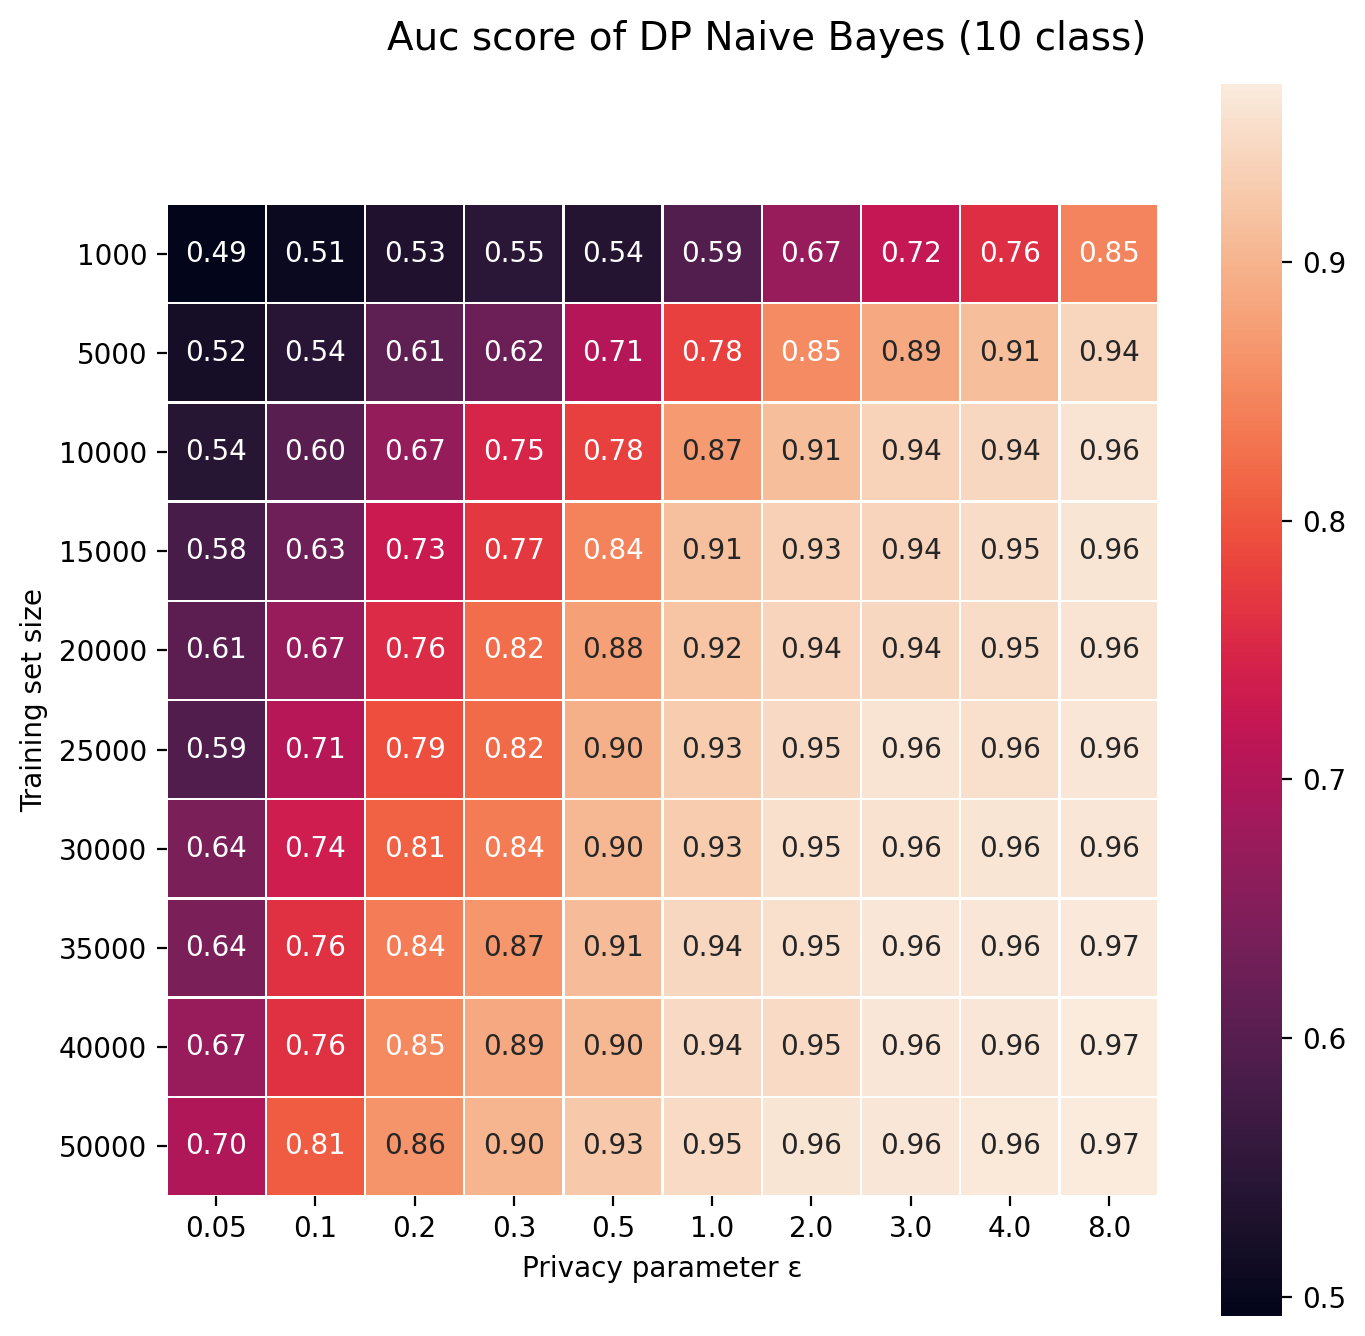

In [20]:
plt.figure(figsize=(8,8))

fig = sns.heatmap(data=result_df, annot=True, fmt='.2f', linewidths=.5, square=True)
fig.set_yticklabels(rotation = 0, labels = training_sizes)

plt.suptitle('Auc score of DP Naive Bayes (10 class)', size=14, y=0.92)   

plt.ylabel('Training set size')
plt.xlabel('Privacy parameter ε')
plt.savefig('results/auc-DPNaiveBayes.png', dpi=300)
plt.show()